In [1]:
import numpy as np
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
from pprint import pprint
import itertools

import cp
import base
from parafac2 import parafac2_als
import parafac2
import utils
import metrics

%matplotlib notebook
np.random.seed(1)

In [2]:
ndims = [30]*10 # 30,20,10
m = 20
true_rank = 2

true_P_k, true_F, true_A, true_D_k = parafac2.create_parafac2_components(ndims, m, true_rank)
true_C = np.diagonal(true_D_k)

In [3]:
with np.printoptions(precision=3, suppress=True):
    for p in true_P_k:
        print(p.T @ p)

[[1. 0.]
 [0. 1.]]
[[ 1. -0.]
 [-0.  1.]]
[[1. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]]
[[ 1. -0.]
 [-0.  1.]]
[[1. 0.]
 [0. 1.]]
[[ 1. -0.]
 [-0.  1.]]
[[1. 0.]
 [0. 1.]]
[[ 1. -0.]
 [-0.  1.]]


In [4]:
X = parafac2.compose_from_parafac2_factors(true_P_k, true_F, true_A, true_D_k)

In [5]:
savemat('/home/marie/Dropbox/Programming/Simula/Parafac2/parafac2_generated_data.mat', 
        {'X': X, 'true_P_k': true_P_k, 'true_A': true_A, 'true_F': 
         true_F, 'true_C': true_C, 'true_rank': true_rank})

In [6]:
P_k, F, A, D_k = parafac2_als(X, true_rank, convergence_th= 1e-5)
C = np.diagonal(D_k)

   0: loss is 1.78, improvement is 0.88
   1: loss is 0.72, improvement is 0.60
   2: loss is 0.74, improvement is -0.03
   3: loss is 0.74, improvement is -0.00
   4: loss is 0.76, improvement is -0.03
   5: loss is 0.80, improvement is -0.05
   6: loss is 0.77, improvement is 0.04
   7: loss is 0.62, improvement is 0.19
   8: loss is 0.46, improvement is 0.26
   9: loss is 0.33, improvement is 0.28
  10: loss is 0.24, improvement is 0.29
  11: loss is 0.17, improvement is 0.27
  12: loss is 0.13, improvement is 0.26
  13: loss is 0.09, improvement is 0.25
  14: loss is 0.07, improvement is 0.23
  15: loss is 0.06, improvement is 0.21
  16: loss is 0.05, improvement is 0.19
  17: loss is 0.04, improvement is 0.16
  18: loss is 0.03, improvement is 0.13
  19: loss is 0.03, improvement is 0.09
  20: loss is 0.03, improvement is 0.07
  21: loss is 0.03, improvement is 0.04
  22: loss is 0.03, improvement is 0.03
  23: loss is 0.03, improvement is 0.02
  24: loss is 0.03, improvement is 0

In [7]:
pred_X = parafac2.compose_from_parafac2_factors(P_k, F, A, D_k)

In [8]:
sse = 0
ss = 0
for px, tx in zip(pred_X, X):
    sse += np.linalg.norm(px-tx, 'fro')**2
    
    ss += np.linalg.norm(tx, 'fro')**2
print('SSE/||X||^2 Python: ', sse/ss)

SSE/||X||^2 Python:  0.007353210010733382


## Get MATLAB results using same data

In [9]:
matlab_results = loadmat('generated_data_matlab_result.mat')

In [10]:
matlab_X_pred = [matlab_results['Xpred'][0, k].astype(float) for k in range(matlab_results['Xpred'].shape[-1])]
matlab_X = [matlab_results['XX'][0, k] for k in range(matlab_results['XX'].shape[-1])]

matlab_F = matlab_results['H']
matlab_P_k = [pk.astype(float) for pk in matlab_results['P'].squeeze()]
matlab_C = matlab_results['C']
matlab_A = matlab_results['A']

In [11]:
sse = 0
ss = 0
for px, tx in zip(matlab_X_pred, matlab_X):
    sse += np.linalg.norm(px-tx, 'fro')**2
    
    ss += np.linalg.norm(tx, 'fro')**2
print('SSE/||X||^2 MATLAB: ', sse/ss)

SSE/||X||^2 MATLAB:  0.0007439193894546478


In [12]:
metrics.factor_match_score([true_A, true_C], [matlab_A, matlab_C], weight_penalty=False)

(0.21719739712960626, (1, 0))

## Factor match score between true factors and python/matlab estimates one mode at a time

In [13]:
weight_penalty = False

In [14]:
fms_A_python, _ = metrics.factor_match_score([true_A], [A], weight_penalty=weight_penalty)
fms_A_matlab, _ = metrics.factor_match_score([true_A], [matlab_A], weight_penalty=weight_penalty)
print(f'FMS for factor A - Python: {fms_A_python:5.4f}, MATLAB: {fms_A_matlab:5.4f}')


fms_C_python, _ = metrics.factor_match_score([true_C], [C], weight_penalty=weight_penalty)
fms_C_matlab, _ = metrics.factor_match_score([true_C], [matlab_C], weight_penalty=weight_penalty)
print(f'FMS for factor C - Python: {fms_C_python:5.4f}, MATLAB: {fms_C_matlab:5.4f}')

FMS for factor A - Python: 0.9980, MATLAB: 0.9983
FMS for factor C - Python: 0.2168, MATLAB: 0.2176


In [15]:
print(f'Factor match score for F_k slice by slice:\n')
for k in range(len(P_k)):
    true_F_k = true_P_k[k] @ true_F
    F_k = P_k[k] @ F
    fms_python,_ = metrics.factor_match_score([true_F_k], [F_k], weight_penalty=weight_penalty)
    
    
    matlab_F_k = matlab_P_k[k] @ matlab_F
    fms_matlab,_ = metrics.factor_match_score([true_F_k], [matlab_F_k], weight_penalty=weight_penalty)
    print(f'F_{k} - Python: {fms_python:5.4f}, MATLAB: {fms_matlab:5.4f}')

Factor match score for F_k slice by slice:

F_0 - Python: 0.9991, MATLAB: 0.9986
F_1 - Python: 0.9361, MATLAB: 0.9396
F_2 - Python: 0.9457, MATLAB: 0.9480
F_3 - Python: 0.9998, MATLAB: 0.9996
F_4 - Python: 0.9366, MATLAB: 0.9390
F_5 - Python: 0.9992, MATLAB: 0.9990
F_6 - Python: 0.9616, MATLAB: 0.9647
F_7 - Python: 0.9616, MATLAB: 0.9624
F_8 - Python: 0.9996, MATLAB: 0.9995
F_9 - Python: 0.9994, MATLAB: 0.9991


## Factor match score between python and matlab estimates one mode at a time

In [16]:
fms_A, _ = metrics.factor_match_score([A], [matlab_A], weight_penalty=weight_penalty)
print(f'FMS between python and matlab decomposition for factor A: {fms_A:5.4f}')

fms_C, _ = metrics.factor_match_score([C], [matlab_C], weight_penalty=weight_penalty)
print(f'FMS between python and matlab decomposition for factor C: {fms_C:5.4f}')

FMS between python and matlab decomposition for factor A: 1.0000
FMS between python and matlab decomposition for factor C: 1.0000


In [17]:
print(f'FMS between python and matlab estimate of F_k slice by slice:\n')
for k in range(len(P_k)):
    F_k = P_k[k] @ F  
    
    matlab_F_k = matlab_P_k[k] @ matlab_F
    fms_F_k,_ = metrics.factor_match_score([F_k], [matlab_F_k], weight_penalty=weight_penalty)
    print(f'F_{k} - {fms_F_k:5.4f}')

FMS between python and matlab estimate of F_k slice by slice:

F_0 - 0.9999
F_1 - 0.9999
F_2 - 1.0000
F_3 - 1.0000
F_4 - 1.0000
F_5 - 1.0000
F_6 - 0.9999
F_7 - 1.0000
F_8 - 1.0000
F_9 - 1.0000


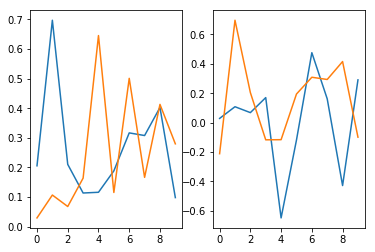

In [19]:
plt.subplot(121)
plt.plot(C)
plt.subplot(122)
plt.plot(true_C)